In [56]:
from PIL import Image
from numpy import *
from pylab import *
import numpy as np
import camera
import homography
import sift
camera = reload(camera)
sift = reload(sift)

In [41]:
def my_calibration(sz):
    row, col = sz
    fx = 3600.0*col/3120
    fy = 3545.0*row/4160
    K = diag([fx, fy, 1])
    K[0,2] = 0.5*col
    K[1,2] = 0.5*row
    return K

In [42]:
def cube_points(c, wid):
    """ Creates a list of points for plotting
    a cube with plot. (the first 5 points are
    the bottom square, some sides repeated). """
    
    p=[]
    #bottom
    p.append([c[0]-wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]-wid,c[2]-wid]) # same as first to close plot

    #top
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]-wid,c[2]+wid]) # same as first to close plot
    
    #vertical sides
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    
    return array(p).T

In [43]:
imname0 = 'marker_small0.jpg'

sift.process_image(imname0, 'im0.sift')
l0, d0 = sift.read_features_from_file('im0.sift')

processed tmp.pgm to im0.sift


(2000, 1600, 3)


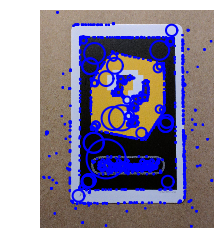

In [44]:
im0 = array(Image.open(imname0))
print im0.shape
figure()
imshow(im0)
sift.plot_features(im0, l0, circle=True)
show()

In [45]:
l1 = []
d1 = []
for i in range(l0.shape[0]):
    x, y, s, w = l0[i]
    if (325<x<1285 and 160<y<1760):
        l1.append(l0[i]) 
        d1.append(d0[i])
l1 = array(l1)
d1 = array(d1)

(2000, 1600, 3)


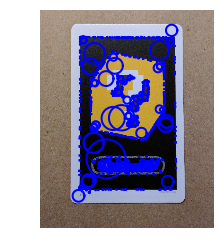

In [46]:
print im0.shape
figure()
imshow(im0)
sift.plot_features(im0, l1, circle=True)
show()

In [47]:
sift.write_features_to_file('marker_small0.sift', l1, d1)

In [48]:
imname1 = 'marker_small0.jpg'
imname2 = 'marker_small2.jpg'

l1, d1 = sift.read_features_from_file('marker_small0.sift')

sift.process_image(imname2, 'im2.sift')
l2, d2 = sift.read_features_from_file('im2.sift')

processed tmp.pgm to im2.sift


(2000, 1600, 3)
(2000, 1600, 3)


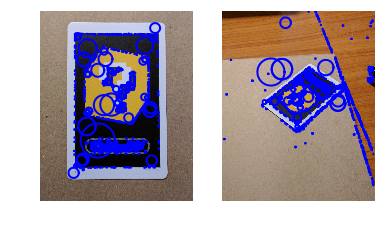

In [49]:
im1 = array(Image.open(imname1))
im2 = array(Image.open(imname2))
print im1.shape
print im2.shape
figure()
subplot(1, 2, 1)
imshow(im1)
sift.plot_features(im1, l1, circle=True)
subplot(1, 2, 2)
imshow(im2)
sift.plot_features(im2, l2, circle=True)
show()

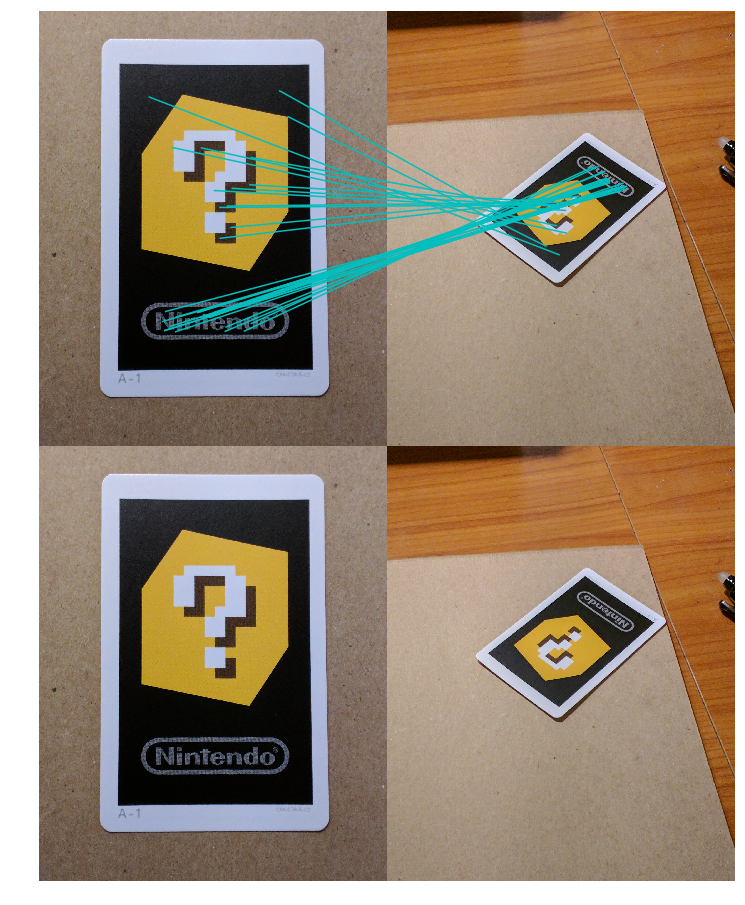

In [36]:
matches = sift.match_twosided(d1, d2)
ndx = matches.nonzero()[0]
fp = homography.make_homog(l1[ndx,:2].T)
ndx2 = [int(matches[i]) for i in ndx]
tp = homography.make_homog(l2[ndx2, :2].T)

figure(figsize=(16, 16))
gray()
sift.plot_matches(im1, im2, l1, l2, matches)
show()

In [50]:
model = homography.RansacModel()
H = homography.H_from_points(fp, tp)

In [39]:
# camera calibration
K = my_calibration((2000, 1600)) # this is the size of the image
print "K"
print K


# 3D points at plane z=0 with sides of length 0.4
box = cube_points([0, 0, 0.2], 0.2)
print 'box'
print box.T

#project bottom square in first image
cam1 = camera.Camera( hstack((K, dot(K, array([[0], [0],[-1]])))))
print "cam1.P"
print cam1.P

#fist points are the bottom square
box_cam1 = cam1.project(homography.make_homog(box[:, :5]))

# use H to transfer points to the second image
box_trans = homography.normalize(dot(H, box_cam1))

# compute second camera matrix from cam1 and H
cam2 = camera.Camera(dot(H, cam1.P))
A = dot(linalg.inv(K), cam2.P[:, :3])
A = array([A[:,0],A[:,1],cross(A[:,0],A[:,1])]).T
cam2.P[:, :3] = dot(K, A)
print "cam2.P"
print cam2.P

#project with the second camera
box_cam2 = cam2.project(homography.make_homog(box))
print 'box_cam2'
print box_cam2.T

#test: projecting point on z=0 should give the same
point = array([1,1,0,1]).T
print "H.P1.points"
print homography.normalize(dot(dot(H,cam1.P),point))
print "camera2 projection"
print cam2.project(point)

K
[[  1.66564103e+03   0.00000000e+00   8.00000000e+02]
 [  0.00000000e+00   1.57259615e+03   1.00000000e+03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
box
[[-0.2 -0.2  0. ]
 [-0.2  0.2  0. ]
 [ 0.2  0.2  0. ]
 [ 0.2 -0.2  0. ]
 [-0.2 -0.2  0. ]
 [-0.2 -0.2  0.4]
 [-0.2  0.2  0.4]
 [ 0.2  0.2  0.4]
 [ 0.2 -0.2  0.4]
 [-0.2 -0.2  0.4]
 [-0.2 -0.2  0.4]
 [-0.2  0.2  0.4]
 [-0.2  0.2  0. ]
 [ 0.2  0.2  0. ]
 [ 0.2  0.2  0.4]
 [ 0.2 -0.2  0.4]
 [ 0.2 -0.2  0. ]]
cam1.P
[[  1.66564103e+03   0.00000000e+00   8.00000000e+02  -8.00000000e+02]
 [  0.00000000e+00   1.57259615e+03   1.00000000e+03  -1.00000000e+03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00  -1.00000000e+00]]
cam2.P
[[ -7.30891968e+02   6.61993371e+02  -4.43518730e+00  -9.27673808e+02]
 [ -5.48280370e+02  -3.09045728e+02   2.26571687e+02  -9.16868618e+02]
 [ -1.52530449e-01   1.87179508e-01   1.92739560e-01  -1.04576610e+00]]
box_cam2
[[  8.68146328e+02   7.08089954e+02   1.00000000e+00]
 [  6.63817487e+02 

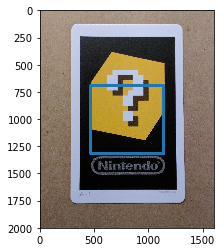

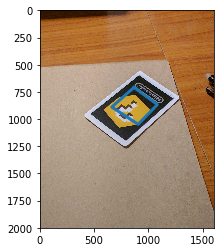

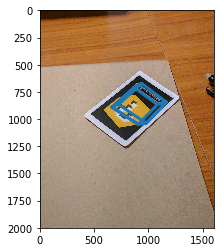

In [53]:
im1 = array(Image.open(imname1))
im2 = array(Image.open(imname2))

figure()
imshow(im1)
plot(box_cam1[0, :], box_cam1[1, :], linewidth=3)

figure()
imshow(im2)
plot(box_trans[0,:], box_trans[1,:], linewidth=3)

figure()
imshow(im2)
plot(box_cam2[0, :], box_cam2[1, :], linewidth=3)

show()

processed tmp.pgm to im1.sift


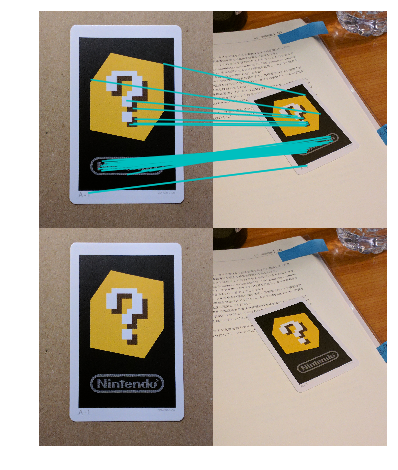

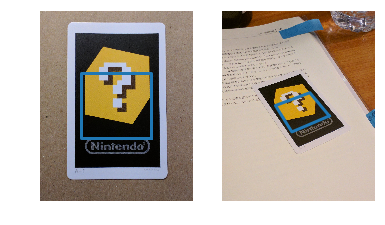

processed tmp.pgm to im2.sift


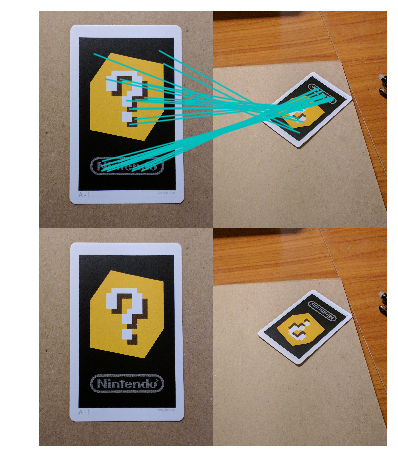

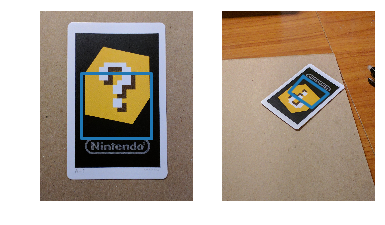

In [59]:
im0 = array(Image.open('marker_small0.jpg'))
l0, d0 = sift.read_features_from_file('marker_small0.sift')
t=[]

for i in range(2):
    imname = 'marker_small'+str(i+1)+'.jpg'
    im1 = array(Image.open(imname))
    sift.process_image(imname, 'im'+str(i+1)+'.sift')
    l1, d1 = sift.read_features_from_file('im'+str(i+1)+'.sift')
    
    matches = sift.match_twosided(d0, d1)
    ndx = matches.nonzero()[0]
    fp = homography.make_homog(l0[ndx,:2].T)
    ndx2 = [int(matches[i]) for i in ndx]
    tp = homography.make_homog(l1[ndx2, :2].T)

    figure(figsize=(8, 8))
    gray()
    sift.plot_matches(im0, im1, l0, l1, matches)
    show()    
    
    
    model = homography.RansacModel()
    try:
        H = homography.H_from_ransac(fp, tp, model, 1000, 10)[0]
    except:
        print imname + " can't be processed."
        continue
    
    # camera calibration
    K = my_calibration((2000, 1600)) # this is the size of the image

    # 3D points at plane z=0 with sides of length 0.4
    box = cube_points([0, 0, 0.2], 0.2)

    #project bottom square in first image
    cam1 = camera.Camera( hstack((K, dot(K, array([[0], [0],[-1]])))))

    #fist points are the bottom square
    box_cam1 = cam1.project(homography.make_homog(box[:, :5]))

    # use H to transfer points to the second image
    box_trans = homography.normalize(dot(H, box_cam1))

    # compute second camera matrix from cam1 and H
    cam2 = camera.Camera(dot(H, cam1.P))
    A = dot(linalg.inv(K), cam2.P[:, :3])
    A = array([A[:,0],A[:,1],cross(A[:,0],A[:,1])]).T
    cam2.P[:, :3] = dot(K, A)

    #project with the second camera
    box_cam2 = cam2.project(homography.make_homog(box))

    figure()
    subplot(1, 2 ,1)
    imshow(im0)
    plot(box_cam1[0, :], box_cam1[1, :], linewidth=3)
    axis('off')
    subplot(1, 2 ,2)
    imshow(im1)
    plot(box_trans[0,:], box_trans[1,:], linewidth=3)
    axis('off')

    #figure()
    #imshow(im1)
    #plot(box_cam2[0, :], box_cam2[1, :], linewidth=3)

    show()
    
    t.append(cam2.center())

In [60]:
print t

[array([ 1.04266205,  2.94828623,  0.14200615]), array([-0.16034255, -4.88571166,  3.69139876])]
